# Welcome to LASER

We will start specifying some parameters here. Meta parameters controlling the simulation itself and disease parameters for infection dynamics.

The `PropertySet()` class is just a convenience class to make code cleaner. E.g., `params.ticks` rather than `params["ticks"]`.

In [1]:
from pathlib import Path

import numpy as np

from idmlaser.utils import PropertySet

meta_params = PropertySet()
meta_params.ticks = 365 * 20
meta_params.nodes = 1
meta_params.seed = 20240612
meta_params.output = Path.cwd() / "outputs"

model_params = PropertySet()
model_params.exp_mean = np.float32(7.0)
model_params.exp_std = np.float32(1.0)
model_params.inf_mean = np.float32(7.0)
model_params.inf_std = np.float32(1.0)
model_params.r_naught = np.float32(14.0)
model_params.seasonality_factor = np.float32(0.1)
model_params.seasonality_offset = np.int32(182.5)

model_params.beta = model_params.r_naught / model_params.inf_mean


-----

## Scenarios

Two scenarios are easily available for modeling: England + Wales (1944-1964 demographics) and Nigeria (2015 population).

The E+W scenario caches just the distances between nodes and builds the node connectivity matrix on the fly from $C(n_i, n_j) = k * \frac {n_i^a * n_j^b} {d_{i,j}^c}$

The Nigeria scenario caches a connectivity matrix from Kurt's work which can be modified by a scaling factor and upper limit on daily "migration".

Each `initialize` function returns the maximum number of agents we need to accomodate (for memory allocation purposes), the demographics over time, the initial distribution of agents in the S/E/I/R states, and the network connectivity matrix.

In [2]:
# England and Wales Scenario
meta_params.scenario = "engwal"

# England and Wales network parameters (we derive connectivity from these and distance)
net_params = PropertySet()
net_params.a = np.float32(1.0)   # pop1 power
net_params.b = np.float32(1.0)   # pop2 power
net_params.c = np.float32(2.0)   # distance power
net_params.k = np.float32(500.0) # scaling factor
net_params.max_frac = np.float32(0.05) # max fraction of population that can migrate

from tests.scenario_engwal import initialize_engwal  # noqa: E402, I001
params = PropertySet(meta_params, model_params, net_params)
max_capacity, demographics, initial, network = initialize_engwal(None, params, params.nodes)    # doesn't need a model, yet

# Nigeria Scenario
# meta_params.scenario = "nigeria"

# Nigeria network parameter(s)
# net_params = PropertySet()
# net_params.k = np.float32(1.0) # scaling factor
# net_params.max_frac = np.float32(0.05) # max fraction of population that can migrate

# from tests.scenario_nigeria import initialize_nigeria
# params = PropertySet(meta_params, model_params, net_params)
# max_capacity, demographics, initial, network = initialize_nigeria(None, params, params.nodes)    # doesn't need a model, yet


Initial population:   2,462,500
Total births:         1,111,495
Total immigrations:     649,201
Max capacity:         4,223,196


-----

## Implementation

We default to the CPU based implementation (NumPy + Numba). The alternative, if running locally or otherwise capable hardware, is the Taichi/GPU implementation.

In [3]:
from datetime import datetime

params.prng_seed = datetime.now(tz=None).microsecond  # noqa: DTZ005

# CPU based implementation
from idmlaser.models.numpynumba import NumbaSpatialSEIR  # noqa: I001, E402, RUF100
model = NumbaSpatialSEIR(params)

# GPU based implementation with Taichi
# from idmlaser.models import TaichiSpatialSEIR  # noqa: I001, E402, RUF100
# model = TaichiSpatialSEIR(params)

model.initialize(max_capacity, demographics, initial, network)

Model parameters: {'exp_mean': 7.0, 'exp_std': 1.0, 'inf_mean': 7.0, 'inf_std': 1.0, 'r_naught': 14.0, 'prng_seed': 867945, 'ticks': 7300, 'nodes': 1, 'seed': 20240612, 'output': PosixPath('/Users/christopherlorton/projects/laser/outputs'), 'scenario': 'engwal', 'seasonality_factor': 0.1, 'seasonality_offset': 182, 'beta': 2.0, 'a': 1.0, 'b': 1.0, 'c': 2.0, 'k': 500.0, 'max_frac': 0.05}
Seeding Numba random number generator with 10 threads
Threading layer chosen: workqueue
Initializing model with 1 nodes: (initial population: 2,462,500 maximum capacity: 4,223,196)


-----

## Running

We run the model for the fully specified number of ticks. Nothing prevents us from running the model for a shorter period of time, inspecting (and possibly modifying) state, and then continuing on with a subsequent `run()` call.

In [4]:
model.run(params.ticks)

100%|██████████| 7300/7300 [00:59<00:00, 123.37it/s]

elapsed time: 0:00:59.237519


-----

### Save results (optional)

The `finalize()` function currently merely writes the parameters used and the results (`model.report`) to disk.

In [5]:
paramfile, npyfile = model.finalize()

Wrote parameters to '/Users/christopherlorton/projects/laser/outputs/20240702-212831-engwal-parameters.json'.
Wrote SEIR channels, by node, to '/Users/christopherlorton/projects/laser/outputs/20240702-212831-engwal-1-7300-spatial_seir.npy'.


-----

## SEIR Channels

Let's plot the SEIR values for a node over the duration of the simulation. For single node simulations without any import pressure, we may have had burnout.

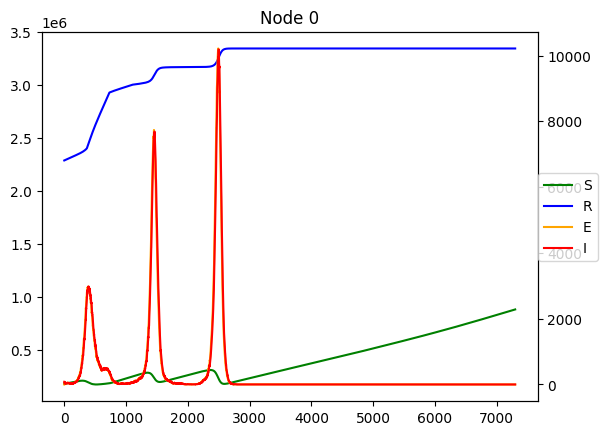

In [6]:
import matplotlib.pyplot as plt

node = 0

# model.report is a 3D numpy array with shape (ticks, compartments, nodes)
S = model.report[:, 0, node]
E = model.report[:, 1, node]
I = model.report[:, 2, node]  # noqa: E741
R = model.report[:, 3, node]

# alternatively, we could load existing data from disk and plot
# saved = np.load(Path('/workspaces/laser/outputs/20240613-190301-engwal-1-7300-spatial_seir.npy'))   # or np.load(npyfile)
# S = saved[:, 0, node]
# E = saved[:, 1, node]
# I = saved[:, 2, node]
# R = saved[:, 3, node]

fig, ax1 = plt.subplots()
plt.plot(S, label="S", color="green")
plt.plot(R, label="R", color="blue")
ax2 = ax1.twinx()
# ax2.set_yscale("log")
plt.plot(E, label="E", color="orange")
plt.plot(I, label="I", color="red")
plt.title(f"Node {node}")
fig.legend(loc="center right")
plt.show()


-----

## I fraction vs. S fraction Over Time

Let's plot I vs. S over time to see if we approach or reach an equilibrium. Color represents time: dark blue at the start of the simulation, dark red at the end.

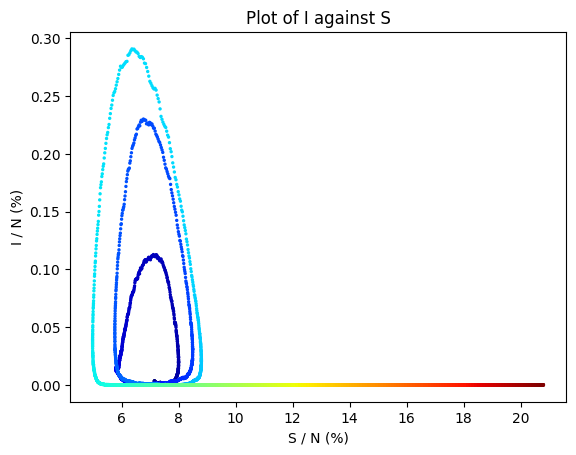

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm

colors = cm.jet(np.linspace(0, 1, params.ticks+1))  # +1 for initial state
N = (S + E + I + R) / 100.0
# N = 1
plt.scatter(S/N, I/N, s=2, color=colors)
plt.xlabel("S / N (%)")
plt.ylabel("I / N (%)")
plt.title("Plot of I against S")
plt.show()

## Timing

vital_dynamics      :       430,864 μsec
infection_update    :     2,659,039 μsec
incubation_update   :     2,629,105 μsec
transmission_update :    13,503,321 μsec
report_update       :    39,401,070 μsec
----------------------------------------
total runtime       :    58,623,399 μsec


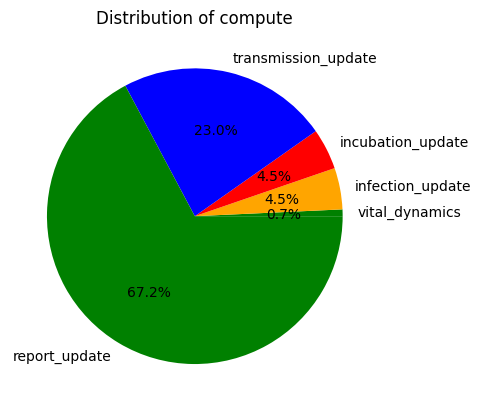

In [8]:
metrics = np.array(model.metrics)

for c in range(metrics.shape[1]):
    if c == 0:
        continue    # Skip the first column, "ticks"
    print(f"{model._phases[c-1].__name__:20}: {metrics[:,c].sum():13,} μsec")
print("----------------------------------------")
print(f"total runtime       : {metrics[:, 1:].sum():13,} μsec")

# metrics.sum(axis=0)[1:]
import matplotlib.pyplot as plt  # noqa: E402

labels = [p.__name__ for p in model._phases]
sizes = metrics.sum(axis=0)[1:]
colors = ["green", "orange", "red", "blue"]

plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%")
plt.title("Distribution of compute")
plt.show()